# Configuration

In [1]:
import os
from tqdm.notebook import tqdm
from tqdm import tqdm
import librosa
import pandas as pd 
import pandas as np
from sklearn.metrics import classification_report

# Clean Data - Compute dataframes for datasets and split in Train, Val, Test 

In [2]:
main_path = '/Users/helemanc/Documents/MasterAI/THESIS/Datasets SER'
TESS = os.path.join(main_path, "tess/TESS Toronto emotional speech set data/") 
RAV = os.path.join(main_path, "ravdess-emotional-speech-audio/audio_speech_actors_01-24")
SAVEE = os.path.join(main_path, "savee/ALL/")
CREMA = os.path.join(main_path, "creamd/AudioWAV/")

## RAVDESS

In [3]:
lst = []
emotion = []
voc_channel = []
full_path = []
modality = []
intensity = []
actors = []
phrase =[]

for root, dirs, files in tqdm(os.walk(RAV)):
    for file in files:
        try:
            #Load librosa array, obtain mfcss, store the file and the mfcss information in a new array
            # X, sample_rate = librosa.load(os.path.join(root,file), res_type='kaiser_fast')
            # mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 
            # The instruction below converts the labels (from 1 to 8) to a series from 0 to 7
            # This is because our predictor needs to start from 0 otherwise it will try to predict also 0.
           
            modal = int(file[1:2])
            vchan = int(file[4:5])
            lab = int(file[7:8])
            ints = int(file[10:11])
            phr = int(file[13:14])
            act = int(file[18:20])
            # arr = mfccs, lab
            # lst.append(arr)
            
            modality.append(modal)
            voc_channel.append(vchan)
            emotion.append(lab) #only labels
            intensity.append(ints)
            phrase.append(phr)
            actors.append(act)
            
            full_path.append((root, file)) # only files
          # If the file is not valid, skip it
        except ValueError:
            continue

25it [00:00, 325.32it/s]


In [4]:
# 01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised
# merge neutral and calm
emotions_list = ['neutral', 'neutral', 'happy', 'sadness', 'angry', 'fear', 'disgust', 'surprise']
emotion_dict = {em[0]+1:em[1] for em in enumerate(emotions_list)}

df = pd.DataFrame([emotion, voc_channel, modality, intensity, actors, actors,phrase, full_path]).T
df.columns = ['emotion', 'voc_channel', 'modality', 'intensity', 'actors', 'gender', 'phrase', 'path']
df['emotion'] = df['emotion'].map(emotion_dict)
df['voc_channel'] = df['voc_channel'].map({1: 'speech', 2:'song'})
df['modality'] = df['modality'].map({1: 'full AV', 2:'video only', 3:'audio only'})
df['intensity'] = df['intensity'].map({1: 'normal', 2:'strong'})
df['actors'] = df['actors']
df['gender'] = df['actors'].apply(lambda x: 'female' if x%2 == 0 else 'male')
df['phrase'] = df['phrase'].map({1: 'Kids are talking by the door', 2:'Dogs are sitting by the door'})
df['path'] = df['path'].apply(lambda x: x[0] + '/' + x[1])

In [5]:
# remove files with noise to apply the same noise to all files for data augmentation 
df = df[~df.path.str.contains('noise')]

In [6]:
df.head()

,emotion,voc_channel,modality,intensity,actors,gender,phrase,path
0,angry,speech,audio only,normal,16,female,Dogs are sitting by the door,/Users/helemanc/Documents/MasterAI/THESIS/Data...
1,fear,speech,audio only,normal,16,female,Dogs are sitting by the door,/Users/helemanc/Documents/MasterAI/THESIS/Data...
2,fear,speech,audio only,strong,16,female,Kids are talking by the door,/Users/helemanc/Documents/MasterAI/THESIS/Data...
3,angry,speech,audio only,strong,16,female,Kids are talking by the door,/Users/helemanc/Documents/MasterAI/THESIS/Data...
5,disgust,speech,audio only,normal,16,female,Kids are talking by the door,/Users/helemanc/Documents/MasterAI/THESIS/Data...


In [7]:
# only speech
RAV_df = df
RAV_df = RAV_df.loc[RAV_df.voc_channel == 'speech']

In [8]:
RAV_df.insert(0, "emotion_label", RAV_df.emotion, True)

In [9]:
RAV_df = RAV_df.drop(['emotion', 'voc_channel', 'modality', 'intensity', 'phrase'], 1)

In [10]:
RAV_df

,emotion_label,actors,gender,path
0,angry,16,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...
1,fear,16,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...
2,fear,16,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...
3,angry,16,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...
5,disgust,16,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...
...,...,...,...,...
2869,happy,8,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...
2871,happy,8,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...
2872,neutral,8,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...
2873,neutral,8,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...


In [11]:
RAV_train = []
RAV_val = []
RAV_test = []

In [12]:
for index, row in RAV_df.iterrows():
    if row['actors'] in range(1,21): 
        RAV_train.append(row) 
    elif row['actors'] in range(21,23): 
        RAV_val.append(row)
    elif row['actors'] in range(23,25): 
        RAV_test.append(row)
len(RAV_train), len(RAV_val), len(RAV_test)

(1200, 120, 120)

In [13]:
RAV_train = pd.DataFrame(RAV_train)
RAV_val = pd.DataFrame(RAV_val)
RAV_test = pd.DataFrame(RAV_test)

In [14]:
RAV_train = RAV_train.drop(['actors'], 1)
RAV_val = RAV_val.drop(['actors'], 1)
RAV_test = RAV_test.drop(['actors'], 1)

In [15]:
RAV_train.reset_index(drop=True, inplace = True) 
RAV_val.reset_index(drop=True, inplace = True) 
RAV_test.reset_index(drop=True, inplace = True ) 

## SAVEE

In [16]:
# Get the data location for SAVEE
dir_list = os.listdir(SAVEE)

# parse the filename to get the emotions
emotion=[]
path = []
actors = []
gender = []
for i in dir_list:
    actors.append(i[:2])
    if i[-8:-6]=='_a':
        emotion.append('angry')
        gender.append('male')
    elif i[-8:-6]=='_d':
        emotion.append('disgust')
        gender.append('male')
    elif i[-8:-6]=='_f':
        emotion.append('fear')
        gender.append('male')
    elif i[-8:-6]=='_h':
        emotion.append('happy')
        gender.append('male')
    elif i[-8:-6]=='_n':
        emotion.append('neutral')
        gender.append('male')
    elif i[-8:-6]=='sa':
        emotion.append('sadness')
        gender.append('male')
    elif i[-8:-6]=='su':
        emotion.append('surprise')
        gender.append('male') 
    else:
        emotion.append('Unknown') 
    path.append(SAVEE + i)
    
# Now check out the label count distribution 
SAVEE_df = pd.DataFrame(emotion, columns = ['emotion_label'])
                      
SAVEE_df = pd.concat([SAVEE_df,
                      pd.DataFrame(actors, columns = ['actors']),
                      pd.DataFrame(gender, columns = ['gender']), 
                      pd.DataFrame(path, columns = ['path'])], axis = 1)
SAVEE_df.emotion_label.value_counts()

neutral     120
fear         60
sadness      60
disgust      60
angry        60
happy        60
surprise     60
Name: emotion_label, dtype: int64

In [17]:
SAVEE_df.head()

,emotion_label,actors,gender,path
0,sadness,JK,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
1,sadness,JK,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
2,neutral,DC,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
3,surprise,DC,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
4,neutral,DC,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...


In [18]:
SAVEE_train = []
SAVEE_val = []
SAVEE_test = []

In [19]:
#DC, JE, JK, KL
for index, row in SAVEE_df.iterrows(): 
    if row['actors'] == 'DC' or row ['actors'] == 'JE':
        SAVEE_train.append(row)
    elif row['actors'] == 'JK': 
        SAVEE_val.append(row)
    else: 
        SAVEE_test.append(row)
len(SAVEE_train), len(SAVEE_val), len(SAVEE_test)

(240, 120, 120)

In [20]:
SAVEE_train = pd.DataFrame(SAVEE_train)
SAVEE_val = pd.DataFrame(SAVEE_val)
SAVEE_test = pd.DataFrame(SAVEE_test)

In [21]:
SAVEE_train = SAVEE_train.drop(['actors'], 1)
SAVEE_val = SAVEE_val.drop(['actors'], 1)
SAVEE_test = SAVEE_test.drop(['actors'], 1)

In [22]:
SAVEE_train = SAVEE_train.reset_index(drop=True) 
SAVEE_val = SAVEE_val.reset_index(drop=True) 
SAVEE_test = SAVEE_test.reset_index(drop=True) 

## TESS

In [23]:
dir_list = os.listdir(TESS)
dir_list.sort()
dir_list

path = []
emotion = []
gender = []
actors = []

for i in dir_list:
    fname = os.listdir(TESS + i)
    for f in fname:
        if i == 'OAF_angry':
            emotion.append('angry')
            gender.append('female')
            actors.append('OAF')
        elif i == 'YAF_angry': 
            emotion.append('angry')
            gender.append('female')
            actors.append('YAF')
            
            
        elif i == 'OAF_disgust' :
            emotion.append('disgust')
            gender.append('female')
            actors.append('OAF')
        elif i == 'YAF_disgust': 
            emotion.append('disgust')
            gender.append('female')
            actors.append('YAF')
            
            
        elif i == 'OAF_Fear':
            emotion.append('fear')
            gender.append('female')
            actors.append('OAF')
        elif i == 'YAF_fear': 
            emotion.append('fear')
            gender.append('female')
            actors.append('YAF') 
            
            
        elif i == 'OAF_happy' :
            emotion.append('happy')
            gender.append('female')
            actors.append('OAF')
        elif i == 'YAF_happy': 
            emotion.append('angry')
            gender.append('female')
            actors.append('YAF')            
            
        elif i == 'OAF_neutral':
            emotion.append('neutral')
            gender.append('female')
            actors.append('OAF')   
        elif i == 'YAF_neutral': 
            emotion.append('neutral')
            gender.append('female')
            actors.append('YAF')      
            
                
        elif i == 'OAF_Pleasant_surprise':
            emotion.append('surprise')
            gender.append('female')
            actors.append('OAF')
        
        elif i == 'YAF_pleasant_surprised': 
            emotion.append('surprise')
            gender.append('female')
            actors.append('YAF')            
            
        elif i == 'OAF_Sad':
            emotion.append('sadness')
            gender.append('female')
            actors.append('OAF')
        elif i == 'YAF_sad': 
            emotion.append('sadness')
            gender.append('female')
            actors.append('YAF')            
        else:
            emotion.append('Unknown')
        path.append(TESS + i + "/" + f)

TESS_df = pd.DataFrame(emotion, columns = ['emotion_label'])
TESS_df = pd.concat([TESS_df, pd.DataFrame(gender, columns = ['gender']), 
                     pd.DataFrame(actors, columns= ['actors']),
                     pd.DataFrame(path, columns = ['path'])],axis=1)
TESS_df.emotion_label.value_counts()

angry       1200
surprise     800
fear         800
sadness      800
neutral      800
disgust      800
happy        400
Name: emotion_label, dtype: int64

In [24]:
TESS_df= TESS_df[~TESS_df.path.str.contains('noise')]

In [25]:
TESS_train = []
TESS_test = []

In [26]:
for index, row in TESS_df.iterrows(): 
    if row['actors'] == 'YAF': 
        TESS_train.append(row)
    else: 
        TESS_test.append(row)
len(TESS_train), len(TESS_test)

(1400, 1400)

In [27]:
TESS_train = pd.DataFrame(TESS_train)
TESS_test = pd.DataFrame(TESS_test)

In [28]:
TESS_train = TESS_train.drop(['actors'], 1)
TESS_test = TESS_test.drop(['actors'], 1)

In [29]:
TESS_train = TESS_train.reset_index(drop=True) 
TESS_test  = TESS_test.reset_index(drop=True) 

## CREMA-D

In [30]:
males = [1,
5,
11,
14,
15,
16,
17,
19,
22,
23,
26,
27,
31,
32,
33,
34,
35,
36,
38,
39,
41,
42,
44,
45,
48,
50,
51,
57,
59, 
62, 
64,
65, 
66,
67,
68,
69,
70,
71,
77, 
80, 
81, 
83, 
85, 
86, 
87,
88, 
90]

In [31]:
females = [ 2,
3,
4,
6,
7,
8,
9,
10,
12,
13,
18,
20,
21,
24,
25,
28,
29,
30,
37,
40,
43,
46,
47,
49,
52,
53,
54,
55,
56, 
58, 
60,
61,
63,
72, 
73, 
74, 
75, 
76, 
78, 
79, 
82, 
84, 
89, 
91]

In [32]:
crema_directory_list = os.listdir(CREMA)

file_emotion = []
file_path = []
actors = []
gender = []




for file in crema_directory_list:

    # storing file emotions
    part=file.split('_')
    
    # use only high intensity files
    if "HI" in part[3] :
        actor = part[0][2:]
        actors.append(actor)
        if int(actor) in males:
            gender.append('male')
        else: 
            gender.append('female')
    
        # storing file paths
        file_path.append(CREMA + file)
        if part[2] == 'SAD':
            file_emotion.append('sadness')
        elif part[2] == 'ANG':
            file_emotion.append('angry')
        elif part[2] == 'DIS':
            file_emotion.append('disgust')
        elif part[2] == 'FEA':
            file_emotion.append('fear')
        elif part[2] == 'HAP':
            file_emotion.append('happy')
        elif part[2] == 'NEU':
            file_emotion.append('neutral')
        else:
            file_emotion.append('Unknown')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['emotion_label'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['path'])
actors_df = pd.DataFrame(actors, columns=['actors'])
gender_df = pd.DataFrame(gender, columns=['gender'])                      
Crema_df = pd.concat([emotion_df, actors_df, gender_df, path_df], axis=1)
Crema_df.head()

,emotion_label,actors,gender,path
0,sadness,28,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...
1,angry,48,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
2,disgust,27,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
3,disgust,32,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
4,happy,80,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...


In [33]:
Crema_df.shape

(455, 4)

In [34]:
actor_files = {}

for index, row in Crema_df.iterrows():
    actor = row['actors']
    if actor not in actor_files.keys(): 
        actor_files[actor] = 1
    else: 
        actor_files[actor]+=1

In [35]:
actor_files

{'28': 5,
 '48': 5,
 '27': 5,
 '32': 5,
 '80': 5,
 '59': 5,
 '39': 5,
 '43': 5,
 '56': 5,
 '31': 5,
 '24': 5,
 '51': 5,
 '44': 5,
 '77': 5,
 '62': 5,
 '88': 5,
 '55': 5,
 '40': 5,
 '13': 5,
 '06': 5,
 '35': 5,
 '20': 5,
 '87': 5,
 '09': 5,
 '78': 5,
 '65': 5,
 '70': 5,
 '23': 5,
 '36': 5,
 '01': 5,
 '14': 5,
 '47': 5,
 '52': 5,
 '58': 5,
 '37': 5,
 '22': 5,
 '71': 5,
 '64': 5,
 '50': 5,
 '45': 5,
 '57': 5,
 '42': 5,
 '29': 5,
 '53': 5,
 '46': 5,
 '33': 5,
 '26': 5,
 '34': 5,
 '21': 5,
 '15': 5,
 '08': 5,
 '86': 5,
 '79': 5,
 '63': 5,
 '76': 5,
 '25': 5,
 '30': 5,
 '07': 5,
 '12': 5,
 '41': 5,
 '54': 5,
 '89': 5,
 '81': 5,
 '49': 5,
 '38': 5,
 '05': 5,
 '10': 5,
 '61': 5,
 '74': 5,
 '69': 5,
 '18': 5,
 '83': 5,
 '17': 5,
 '02': 5,
 '73': 5,
 '66': 5,
 '84': 5,
 '91': 5,
 '90': 5,
 '85': 5,
 '03': 5,
 '16': 5,
 '67': 5,
 '72': 5,
 '68': 5,
 '82': 5,
 '19': 5,
 '11': 5,
 '04': 5,
 '75': 5,
 '60': 5}

In [36]:
count_males = 0 
count_females = 0 
male_list = []
for index, row in Crema_df.iterrows(): 
    gender = row['gender']
    actor = row['actors']
    if gender == 'male':
        count_males +=1
        if actor not in male_list: 
            male_list.append(actor)
    else: 
        count_females +=1

In [37]:
count_males, count_females

(235, 220)

Since there are more males than females we will remove randomly 3 male actors (since there are exactly 5 audio files per actor)

In [38]:
import random 
'''
random.seed(42)
males_to_remove = random.sample(male_list, 3)
males_to_remove
'''
males_to_remove = ['17', '80', '88']

In [39]:
new_df = []
for index, row in Crema_df.iterrows(): 
    if row['actors'] not in males_to_remove: 
        new_df.append(row)

In [40]:
CREMA_df = pd.DataFrame(new_df)

In [41]:
for index, row in CREMA_df.iterrows(): 
    if row['actors'] == '17': 
        print("Elements not removed")

In [42]:
count_males = 0 
count_females = 0 
male_list = []
female_list = []
for index, row in CREMA_df.iterrows(): 
    gender = row['gender']
    actor = row['actors']
    if gender == 'male':
        count_males +=1
        if actor not in male_list: 
            male_list.append(actor)
    else: 
        count_females +=1
        if actor not in female_list: 
            female_list.append(actor)

In [43]:
count_males, count_females

(220, 220)

In [44]:
len(female_list)

44

In [45]:
len(male_list)

44

In [46]:
CREMA_train = []
CREMA_val = []
CREMA_test = []

In [47]:
females_train = random.sample(female_list, 32)
males_train = random.sample(male_list, 32)

# remove the elements assigned to train 
for element in females_train:
    if element in female_list:
        female_list.remove(element)
        
for element in males_train:
    if element in male_list:
        male_list.remove(element)

         
females_val = random.sample(female_list, 6) 
males_val = random.sample(male_list, 6) 

# remove the elements assigned to val
for element in females_val:
    if element in female_list:
        female_list.remove(element)
        
for element in males_val:
    if element in male_list:
        male_list.remove(element)
        
females_test = random.sample(female_list, 6) 
males_test = random.sample(male_list, 6)        

In [48]:
females_train, males_train, females_val, males_val, females_test, males_test

(['07',
  '58',
  '18',
  '12',
  '53',
  '09',
  '40',
  '49',
  '03',
  '37',
  '54',
  '08',
  '24',
  '55',
  '29',
  '79',
  '56',
  '89',
  '61',
  '52',
  '84',
  '21',
  '63',
  '75',
  '20',
  '02',
  '04',
  '06',
  '73',
  '74',
  '60',
  '43'],
 ['59',
  '05',
  '66',
  '11',
  '90',
  '23',
  '34',
  '77',
  '41',
  '42',
  '14',
  '62',
  '83',
  '50',
  '22',
  '19',
  '69',
  '32',
  '44',
  '45',
  '85',
  '26',
  '39',
  '15',
  '16',
  '35',
  '87',
  '48',
  '71',
  '57',
  '36',
  '01'],
 ['78', '30', '82', '76', '91', '47'],
 ['67', '68', '51', '65', '64', '31'],
 ['72', '10', '25', '13', '46', '28'],
 ['86', '38', '27', '81', '33', '70'])

In [49]:
train = females_train + males_train 
val = females_val + males_val 
test = females_test + males_test

In [50]:
for index, row in CREMA_df.iterrows(): 
    gender = row['gender']
    actor = row['actors']
    if actor in train: 
        CREMA_train.append(row)
    elif actor in val: 
        CREMA_val.append(row)
    else:
        CREMA_test.append(row)

In [51]:
CREMA_train = pd.DataFrame(CREMA_train) 
CREMA_val = pd.DataFrame(CREMA_val) 
CREMA_test = pd.DataFrame(CREMA_test)

In [52]:
CREMA_train.shape, CREMA_val.shape, CREMA_test.shape

((320, 4), (60, 4), (60, 4))

In [53]:
CREMA_train = CREMA_train.drop(['actors'], 1)
CREMA_val = CREMA_val.drop(['actors'], 1)
CREMA_test = CREMA_test.drop(['actors'], 1)

In [54]:
CREMA_train = CREMA_train.reset_index(drop=True) 
CREMA_val = CREMA_val.reset_index(drop = True) 
CREMA_test = CREMA_test.reset_index(drop = True)

# Utils Validation Ensemble

In [55]:
# import main
from inaSpeechSegmenter import Segmenter
from argparse import ArgumentParser
import utils
import warnings

In [56]:
# import utils
from speech_emotion_recognition import feature_extraction as fe, ensemble
import scipy
import numpy as np
from scipy import signal
from scipy.io.wavfile import write
from utils import resample, denoise

In [57]:
# other imports 
import sklearn
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
# print('The scikit-learn version is {}.'.format(sklearn.__version__))

In [58]:
#!pip install scikit-learn==0.24.2

In [59]:
#!jupyter nbextension enable --py widgetsnbextension

In [60]:
#!jupyter labextension install @jupyter-widgets/jupyterlab-manager

In [61]:
def make_predictions(dataset, labels, prediction_scheme): 
    predictions = []
    model_predictions_list = []
    counter = 0
    for filepath in tqdm(dataset['path']):
        samples, sample_rate = fe.read_file(filepath)
        samples, sample_rate = resample(samples, sample_rate)
        new_samples = fe.cut_pad(samples)
        #new_filepath = "tmp.wav"
        final_prediction, model_predictions = ensemble.ensemble(new_samples, prediction_scheme, return_model_predictions = True)

        predictions.append(final_prediction)
        model_predictions_list.append(model_predictions) 
        print("True label", labels[counter], "Predicted label", predictions[counter])
        counter+=1
    return predictions, model_predictions_list

def create_dataframe_prediction_per_model(model_predictions_list):
    df_model_predictions = pd.DataFrame(model_predictions_list)
    df_model_predictions = df_model_predictions.reindex(sorted(df_model_predictions.columns), axis=1)
    return df_model_predictions
    
def create_dataframe_predictions(prediction_list):
    df_predictions = pd.DataFrame(prediction_list)
    return df_predictions

def create_dataframe_res(labels, df_predictions, df_model_predictions, dataset): 
    df_res = pd.concat([labels, 
                    df_predictions, 
                    df_model_predictions, 
                    dataset.path], axis = 1, ignore_index=True, sort=False)
    header_model_predictions = list(df_model_predictions.columns)
    new_header = []
    new_header.append('true_label')
    new_header.append('pred_label')
    new_header = new_header + header_model_predictions
    new_header.append('path')
    df_res.columns = new_header
    return df_res
    
def create_dataframes_false_positives_false_negatives(df_res): 
    misclassified_rows_false_positives = []
    misclassified_rows_false_negatives = []
    for index, row in df_res.iterrows():
        true = df_res.true_label[index]
        pred = df_res.pred_label[index]
        if true != pred: # store misclassified files
            if true ==1 and pred == 0: # disruptive classified as non-distruptive is false negative
                misclassified_rows_false_negatives.append(row)
            else:
                misclassified_rows_false_positives.append(row)  
    df_false_negatives = pd.DataFrame(misclassified_rows_false_negatives)
    df_false_negatives.reset_index(drop=True, inplace=True)

    df_false_positives = pd.DataFrame(misclassified_rows_false_positives)
    df_false_positives.reset_index(drop=True, inplace=True)
    
    return df_false_positives, df_false_negatives

def print_hist_models_predictions_fp(df_false_positives): 
    
    if df_false_positives.empty:
        print('DataFrame False Positives is empty!')
        return 0
    df_models_fp = df_false_positives.copy()
    df_models_fp.drop(columns=['true_label', 'pred_label', 'path'])
    df_models_fp.hist(figsize=(24,24))
    
def print_hist_models_predictions_fn(df_false_negatives): 
    if df_false_negatives.empty:
        print('DataFrame False Negatives is empty!')
        return 0
    df_models_fn = df_false_negatives.copy()
    df_models_fn.drop(columns=['true_label', 'pred_label', 'path'])
    df_models_fn.hist(figsize=(24,24))

# Validation  - RAVDESS

We use the same code of the main.py of the real application, without VAD module

In [62]:
emotion_enc = {'fear':1, 'disgust':1, 'neutral':0, 'calm':0,  'happy':0, 'sadness':1, 'surprise':0, 'angry':1}
labels= pd.Series(list(RAV_test.emotion_label)).replace(emotion_enc)

In [63]:
predictions, model_prediction_list = make_predictions(RAV_test, labels, prediction_scheme='majority')

  1%|          | 1/120 [00:10<21:21, 10.77s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 1


  2%|▏         | 2/120 [00:20<20:21, 10.35s/it]

[1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0]
True label 1 Predicted label 1


  2%|▎         | 3/120 [00:31<21:00, 10.77s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


  3%|▎         | 4/120 [00:42<20:27, 10.58s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1


  4%|▍         | 5/120 [00:57<23:16, 12.14s/it]

[1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


  5%|▌         | 6/120 [01:09<22:53, 12.04s/it]

[1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 1


  6%|▌         | 7/120 [01:22<23:11, 12.31s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


  7%|▋         | 8/120 [01:36<24:03, 12.89s/it]

[1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


  8%|▊         | 9/120 [01:49<23:29, 12.69s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


  8%|▊         | 10/120 [02:00<22:37, 12.34s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


  9%|▉         | 11/120 [02:13<22:57, 12.64s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 10%|█         | 12/120 [02:26<22:33, 12.54s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


 11%|█         | 13/120 [02:38<22:02, 12.36s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


 12%|█▏        | 14/120 [02:49<21:25, 12.13s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


 12%|█▎        | 15/120 [03:01<21:16, 12.16s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 13%|█▎        | 16/120 [03:13<20:36, 11.89s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 14%|█▍        | 17/120 [03:23<19:36, 11.42s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


 15%|█▌        | 18/120 [03:33<18:48, 11.06s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


 16%|█▌        | 19/120 [03:45<18:45, 11.15s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


 17%|█▋        | 20/120 [03:59<20:13, 12.14s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 18%|█▊        | 21/120 [04:12<20:34, 12.47s/it]

[1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 1


 18%|█▊        | 22/120 [04:24<19:44, 12.09s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 1


 19%|█▉        | 23/120 [04:34<18:59, 11.74s/it]

[1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 20%|██        | 24/120 [04:48<19:45, 12.35s/it]

[1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 21%|██        | 25/120 [05:02<20:26, 12.91s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 1


 22%|██▏       | 26/120 [05:13<18:57, 12.11s/it]

[1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0]
True label 1 Predicted label 0


 22%|██▎       | 27/120 [05:28<20:12, 13.04s/it]

[1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 23%|██▎       | 28/120 [05:43<20:46, 13.55s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 24%|██▍       | 29/120 [05:56<20:30, 13.52s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 25%|██▌       | 30/120 [06:08<19:27, 12.97s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 26%|██▌       | 31/120 [06:20<19:05, 12.87s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 27%|██▋       | 32/120 [06:38<20:59, 14.31s/it]

[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


 28%|██▊       | 33/120 [06:50<19:48, 13.66s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


 28%|██▊       | 34/120 [07:05<20:09, 14.07s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


 29%|██▉       | 35/120 [07:14<17:49, 12.59s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


 30%|███       | 36/120 [07:26<17:08, 12.24s/it]

[1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 31%|███       | 37/120 [07:37<16:33, 11.97s/it]

[1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 32%|███▏      | 38/120 [07:47<15:28, 11.33s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 32%|███▎      | 39/120 [07:58<15:18, 11.35s/it]

[1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1]
True label 1 Predicted label 1


 33%|███▎      | 40/120 [08:09<14:52, 11.16s/it]

[1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1


 34%|███▍      | 41/120 [08:20<14:43, 11.19s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 35%|███▌      | 42/120 [08:34<15:27, 11.89s/it]

[1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 36%|███▌      | 43/120 [08:46<15:20, 11.96s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 1


 37%|███▋      | 44/120 [08:57<14:45, 11.65s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]
True label 0 Predicted label 0


 38%|███▊      | 45/120 [09:09<14:43, 11.78s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 38%|███▊      | 46/120 [09:21<14:32, 11.80s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 39%|███▉      | 47/120 [09:31<13:55, 11.45s/it]

[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 40%|████      | 48/120 [09:43<13:41, 11.41s/it]

[1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 1


 41%|████      | 49/120 [09:53<13:06, 11.07s/it]

[1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 42%|████▏     | 50/120 [10:03<12:35, 10.79s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 42%|████▎     | 51/120 [10:13<12:09, 10.57s/it]

[1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 1


 43%|████▎     | 52/120 [10:24<12:09, 10.73s/it]

[1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 1


 44%|████▍     | 53/120 [10:35<11:54, 10.66s/it]

[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1]
True label 1 Predicted label 1


 45%|████▌     | 54/120 [10:47<12:13, 11.11s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 46%|████▌     | 55/120 [10:59<12:13, 11.28s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 47%|████▋     | 56/120 [11:11<12:19, 11.55s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 48%|████▊     | 57/120 [11:22<12:03, 11.48s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 48%|████▊     | 58/120 [11:34<11:57, 11.57s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


 49%|████▉     | 59/120 [11:44<11:25, 11.25s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 50%|█████     | 60/120 [11:56<11:13, 11.23s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


 51%|█████     | 61/120 [12:07<11:10, 11.36s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 52%|█████▏    | 62/120 [12:18<10:39, 11.02s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 52%|█████▎    | 63/120 [12:28<10:22, 10.92s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0]
True label 0 Predicted label 0


 53%|█████▎    | 64/120 [12:38<09:54, 10.61s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 54%|█████▍    | 65/120 [12:48<09:34, 10.44s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]
True label 0 Predicted label 0


 55%|█████▌    | 66/120 [13:00<09:51, 10.96s/it]

[1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1


 56%|█████▌    | 67/120 [13:12<09:44, 11.03s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 1


 57%|█████▋    | 68/120 [13:23<09:40, 11.17s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1


 57%|█████▊    | 69/120 [13:35<09:48, 11.54s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1]
True label 1 Predicted label 0


 58%|█████▊    | 70/120 [13:49<10:01, 12.03s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


 59%|█████▉    | 71/120 [13:59<09:32, 11.68s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 1


 60%|██████    | 72/120 [14:10<09:08, 11.42s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 61%|██████    | 73/120 [14:28<10:30, 13.41s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 62%|██████▏   | 74/120 [14:40<09:58, 13.02s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]
True label 0 Predicted label 1


 62%|██████▎   | 75/120 [14:52<09:21, 12.49s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 63%|██████▎   | 76/120 [15:02<08:44, 11.93s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1


 64%|██████▍   | 77/120 [15:12<08:06, 11.31s/it]

[1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 65%|██████▌   | 78/120 [15:23<07:54, 11.30s/it]

[1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1]
True label 1 Predicted label 1


 66%|██████▌   | 79/120 [15:34<07:36, 11.15s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 1


 67%|██████▋   | 80/120 [15:45<07:24, 11.12s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 68%|██████▊   | 81/120 [15:58<07:33, 11.62s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 0


 68%|██████▊   | 82/120 [16:09<07:13, 11.41s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 69%|██████▉   | 83/120 [16:19<06:48, 11.05s/it]

[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 0


 70%|███████   | 84/120 [16:32<06:53, 11.50s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


 71%|███████   | 85/120 [16:42<06:28, 11.10s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]
True label 0 Predicted label 0


 72%|███████▏  | 86/120 [16:52<06:04, 10.71s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 72%|███████▎  | 87/120 [17:02<05:53, 10.71s/it]

[0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0]
True label 0 Predicted label 0


 73%|███████▎  | 88/120 [17:13<05:40, 10.66s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]
True label 0 Predicted label 0


 74%|███████▍  | 89/120 [17:23<05:20, 10.34s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0]
True label 0 Predicted label 0


 75%|███████▌  | 90/120 [17:32<05:04, 10.14s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


 76%|███████▌  | 91/120 [17:43<04:58, 10.30s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 77%|███████▋  | 92/120 [17:53<04:42, 10.10s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 1


 78%|███████▊  | 93/120 [18:03<04:34, 10.17s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 78%|███████▊  | 94/120 [18:13<04:23, 10.14s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0]
True label 1 Predicted label 0


 79%|███████▉  | 95/120 [18:25<04:24, 10.57s/it]

[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1]
True label 1 Predicted label 0


 80%|████████  | 96/120 [18:35<04:14, 10.61s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 1


 81%|████████  | 97/120 [18:46<04:04, 10.63s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 1


 82%|████████▏ | 98/120 [18:57<03:57, 10.82s/it]

[0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 1


 82%|████████▎ | 99/120 [19:08<03:46, 10.78s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0]
True label 0 Predicted label 0


 83%|████████▎ | 100/120 [19:18<03:29, 10.47s/it]

[0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]
True label 0 Predicted label 1


 84%|████████▍ | 101/120 [19:27<03:10, 10.03s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0]
True label 0 Predicted label 0


 85%|████████▌ | 102/120 [19:39<03:16, 10.89s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]
True label 0 Predicted label 0


 86%|████████▌ | 103/120 [19:49<02:58, 10.50s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]
True label 0 Predicted label 0


 87%|████████▋ | 104/120 [19:58<02:39,  9.95s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 88%|████████▊ | 105/120 [20:08<02:29,  9.96s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 88%|████████▊ | 106/120 [20:18<02:19,  9.98s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


 89%|████████▉ | 107/120 [20:28<02:09,  9.98s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0]
True label 0 Predicted label 0


 90%|█████████ | 108/120 [20:38<02:02, 10.20s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0]
True label 0 Predicted label 0


 91%|█████████ | 109/120 [20:50<01:54, 10.45s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
True label 0 Predicted label 0


 92%|█████████▏| 110/120 [21:02<01:51, 11.14s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0]
True label 0 Predicted label 0


 92%|█████████▎| 111/120 [21:14<01:40, 11.18s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 1


 93%|█████████▎| 112/120 [21:25<01:30, 11.31s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 94%|█████████▍| 113/120 [21:37<01:19, 11.42s/it]

[0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0]
True label 1 Predicted label 0


 95%|█████████▌| 114/120 [21:48<01:07, 11.25s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 96%|█████████▌| 115/120 [21:58<00:54, 10.88s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 1


 97%|█████████▋| 116/120 [22:09<00:43, 10.87s/it]

[1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 98%|█████████▊| 117/120 [22:18<00:31, 10.57s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 98%|█████████▊| 118/120 [22:30<00:21, 10.79s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1


 99%|█████████▉| 119/120 [22:39<00:10, 10.24s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0]
True label 0 Predicted label 0


100%|██████████| 120/120 [22:49<00:00, 11.41s/it]

[0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1]
True label 0 Predicted label 1


In [64]:
df_model_predictions = create_dataframe_prediction_per_model(model_prediction_list)
df_predictions = create_dataframe_predictions(predictions)
df_res = create_dataframe_res(labels, df_predictions, df_model_predictions, RAV_test)
df_fp, df_fn = create_dataframes_false_positives_false_negatives(df_res)

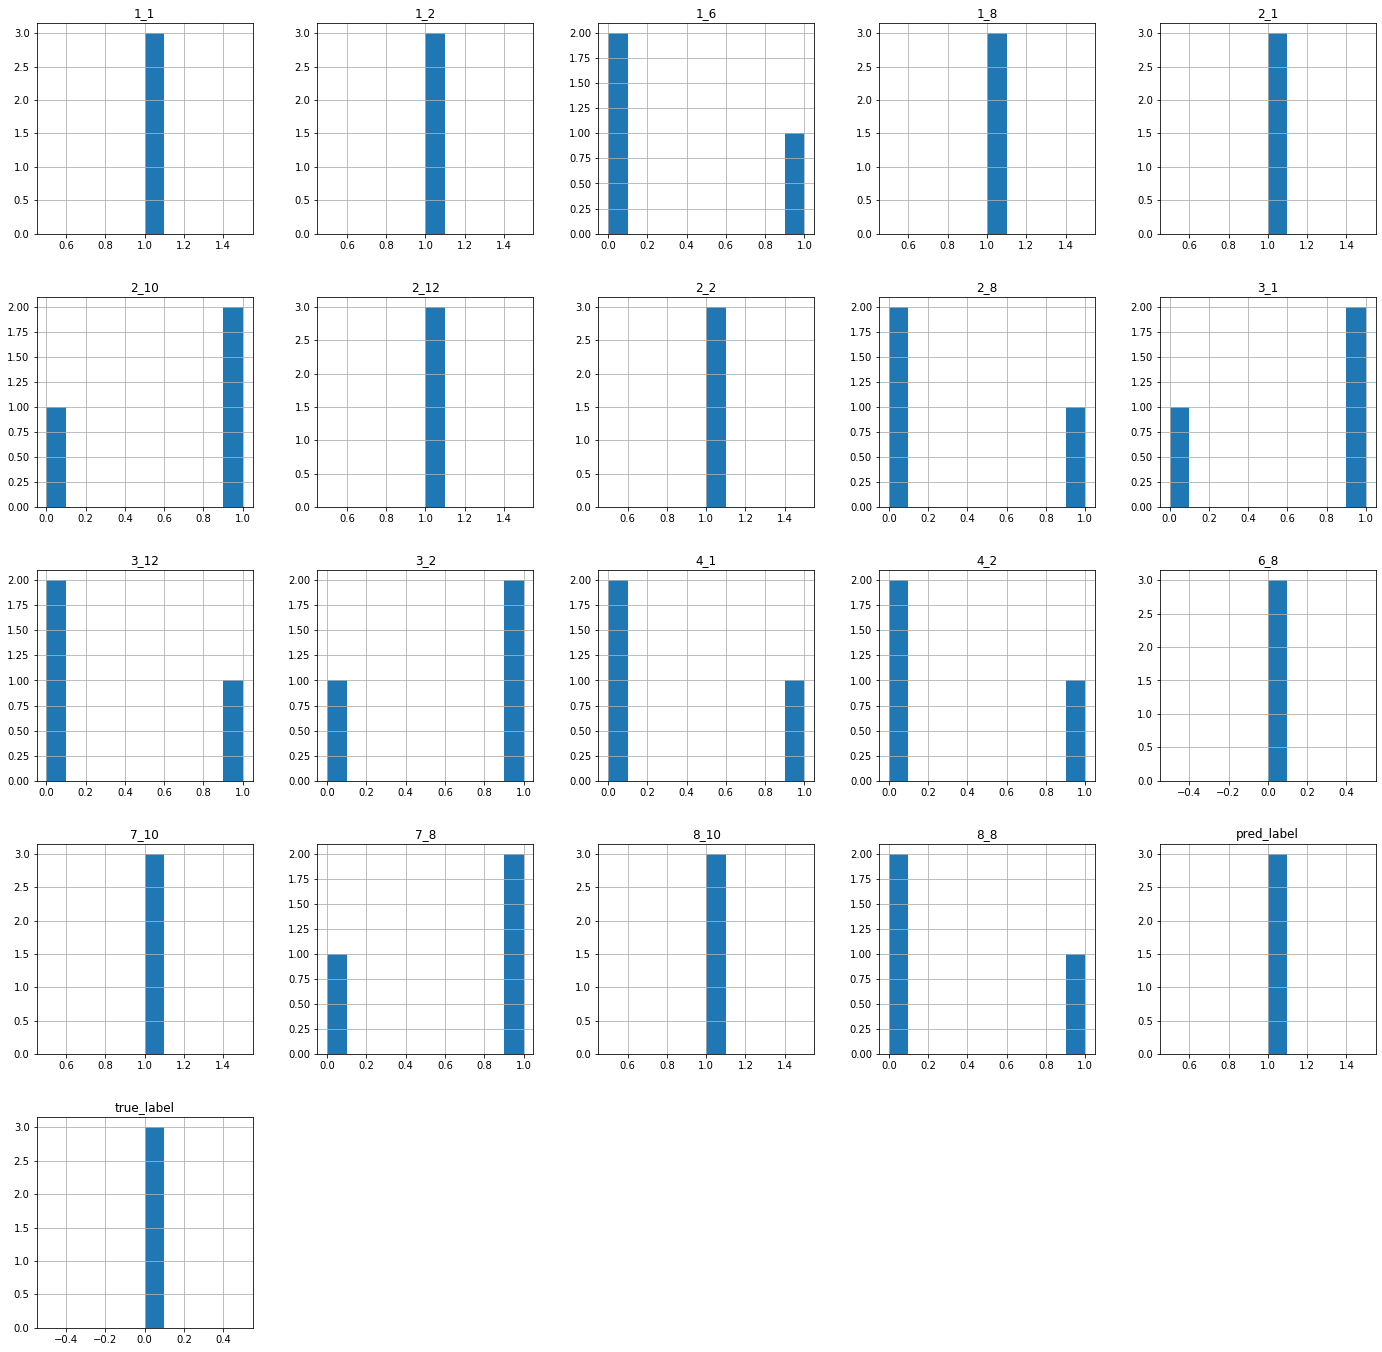

In [71]:
print_hist_models_predictions_fp(df_fp)

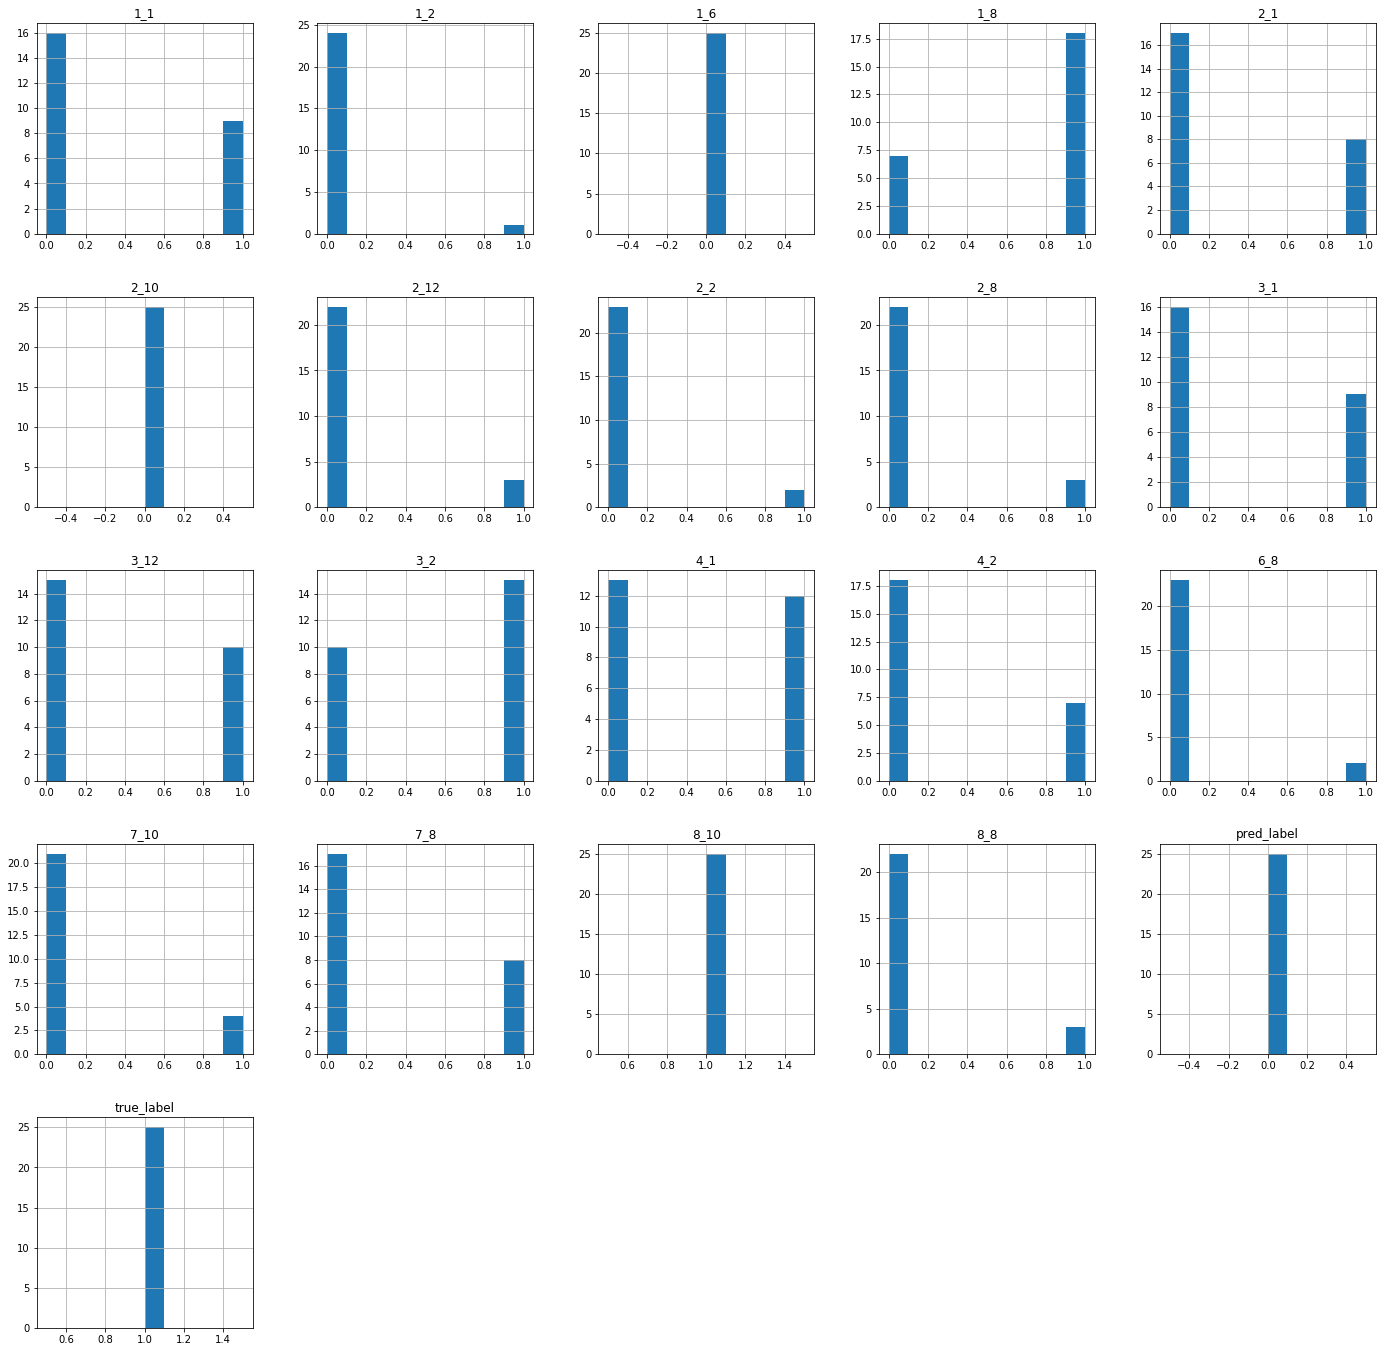

In [72]:
print_hist_models_predictions_fn(df_fn)

In [73]:
print(classification_report(df_res.true_label, df_res.pred_label))

              precision    recall  f1-score   support

           0       0.68      0.95      0.79        56
           1       0.93      0.61      0.74        64

    accuracy                           0.77       120
   macro avg       0.80      0.78      0.76       120
weighted avg       0.81      0.77      0.76       120



In [74]:
csv_path = "/Users/helemanc/PycharmProjects/ambient-intelligence/speech_emotion_recognition/ensemble_validation_results/majority_validation_ravdess_0_7.csv"
df_res.to_csv(csv_path)

# Validation - CREMA

We use the same code of the main.py of the real application, without VAD module

In [75]:
emotion_enc = {'fear':1, 'disgust':1, 'neutral':0, 'calm':0,  'happy':0, 'sadness':1, 'surprise':0, 'angry':1}
labels= pd.Series(list(CREMA_test.emotion_label)).replace(emotion_enc)

In [76]:
predictions, model_prediction_list = make_predictions(CREMA_test, labels, prediction_scheme='majority')

  2%|▏         | 1/60 [00:12<12:32, 12.75s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1]
True label 1 Predicted label 0


  3%|▎         | 2/60 [00:22<11:33, 11.95s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


  5%|▌         | 3/60 [00:33<10:58, 11.55s/it]

[0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


  7%|▋         | 4/60 [00:47<11:35, 12.42s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


  8%|▊         | 5/60 [00:59<11:03, 12.06s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 10%|█         | 6/60 [01:11<10:52, 12.07s/it]

[0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


 12%|█▏        | 7/60 [01:21<10:15, 11.60s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]
True label 1 Predicted label 0


 13%|█▎        | 8/60 [01:37<11:09, 12.88s/it]

[0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 15%|█▌        | 9/60 [01:50<11:01, 12.98s/it]

[0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


 17%|█▋        | 10/60 [02:06<11:26, 13.72s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1]
True label 1 Predicted label 0


 18%|█▊        | 11/60 [02:17<10:40, 13.08s/it]

[0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 20%|██        | 12/60 [02:29<10:07, 12.67s/it]

[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 22%|██▏       | 13/60 [02:41<09:40, 12.35s/it]

[0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


 23%|██▎       | 14/60 [02:53<09:23, 12.24s/it]

[0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 25%|██▌       | 15/60 [03:05<09:08, 12.19s/it]

[1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


 27%|██▋       | 16/60 [03:16<08:50, 12.06s/it]

[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 28%|██▊       | 17/60 [03:28<08:32, 11.91s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


 30%|███       | 18/60 [03:40<08:18, 11.86s/it]

[1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 32%|███▏      | 19/60 [03:52<08:10, 11.97s/it]

[1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 33%|███▎      | 20/60 [04:01<07:24, 11.12s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 35%|███▌      | 21/60 [04:15<07:44, 11.91s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1]
True label 1 Predicted label 0


 37%|███▋      | 22/60 [04:29<07:57, 12.58s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1]
True label 1 Predicted label 0


 38%|███▊      | 23/60 [04:45<08:28, 13.73s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


 40%|████      | 24/60 [04:59<08:10, 13.64s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 42%|████▏     | 25/60 [05:16<08:33, 14.66s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1]
True label 1 Predicted label 0


 43%|████▎     | 26/60 [05:28<07:47, 13.75s/it]

[1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 45%|████▌     | 27/60 [05:42<07:41, 14.00s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]
True label 1 Predicted label 0


 47%|████▋     | 28/60 [06:00<08:06, 15.20s/it]

[0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 48%|████▊     | 29/60 [06:12<07:19, 14.18s/it]

[1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1]
True label 1 Predicted label 1


 50%|█████     | 30/60 [06:24<06:49, 13.65s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]
True label 1 Predicted label 0


 52%|█████▏    | 31/60 [06:35<06:12, 12.84s/it]

[1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1]
True label 1 Predicted label 1


 53%|█████▎    | 32/60 [06:48<05:55, 12.71s/it]

[1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


 55%|█████▌    | 33/60 [07:04<06:12, 13.79s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


 57%|█████▋    | 34/60 [07:18<05:57, 13.75s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]
True label 1 Predicted label 0


 58%|█████▊    | 35/60 [07:27<05:13, 12.56s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]
True label 1 Predicted label 0


 60%|██████    | 36/60 [07:36<04:35, 11.50s/it]

[0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]
True label 1 Predicted label 0


 62%|██████▏   | 37/60 [07:45<04:07, 10.74s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1]
True label 1 Predicted label 0


 63%|██████▎   | 38/60 [07:54<03:43, 10.16s/it]

[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


 65%|██████▌   | 39/60 [08:04<03:32, 10.11s/it]

[1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1]
True label 1 Predicted label 1


 67%|██████▋   | 40/60 [08:13<03:11,  9.58s/it]

[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 68%|██████▊   | 41/60 [08:21<02:55,  9.26s/it]

[1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 70%|███████   | 42/60 [08:29<02:41,  8.97s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]
True label 1 Predicted label 0


 72%|███████▏  | 43/60 [08:38<02:30,  8.84s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]
True label 1 Predicted label 0


 73%|███████▎  | 44/60 [08:46<02:18,  8.64s/it]

[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 75%|███████▌  | 45/60 [08:54<02:07,  8.48s/it]

[0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1]
True label 1 Predicted label 1


 77%|███████▋  | 46/60 [09:03<01:58,  8.47s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1]
True label 1 Predicted label 0


 78%|███████▊  | 47/60 [09:11<01:48,  8.36s/it]

[0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]
True label 1 Predicted label 0


 80%|████████  | 48/60 [09:19<01:40,  8.41s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1]
True label 1 Predicted label 0


 82%|████████▏ | 49/60 [09:28<01:33,  8.51s/it]

[1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1]
True label 1 Predicted label 1


 83%|████████▎ | 50/60 [09:37<01:25,  8.52s/it]

[1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1]
True label 1 Predicted label 1


 85%|████████▌ | 51/60 [09:45<01:15,  8.39s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1]
True label 1 Predicted label 0


 87%|████████▋ | 52/60 [09:53<01:07,  8.46s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


 88%|████████▊ | 53/60 [10:07<01:10, 10.07s/it]

[0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


 90%|█████████ | 54/60 [10:24<01:13, 12.19s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]
True label 1 Predicted label 0


 92%|█████████▏| 55/60 [10:35<00:58, 11.78s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1]
True label 1 Predicted label 0


 93%|█████████▎| 56/60 [10:49<00:49, 12.40s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]
True label 1 Predicted label 0


 95%|█████████▌| 57/60 [11:00<00:35, 11.99s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1]
True label 1 Predicted label 0


 97%|█████████▋| 58/60 [11:13<00:24, 12.24s/it]

[1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 98%|█████████▊| 59/60 [11:24<00:11, 11.79s/it]

[0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1]
True label 0 Predicted label 1


100%|██████████| 60/60 [11:34<00:00, 11.57s/it]

[0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


In [77]:
df_model_predictions = create_dataframe_prediction_per_model(model_prediction_list)
df_predictions = create_dataframe_predictions(predictions)
df_res = create_dataframe_res(labels, df_predictions, df_model_predictions, CREMA_test)
df_fp, df_fn = create_dataframes_false_positives_false_negatives(df_res)

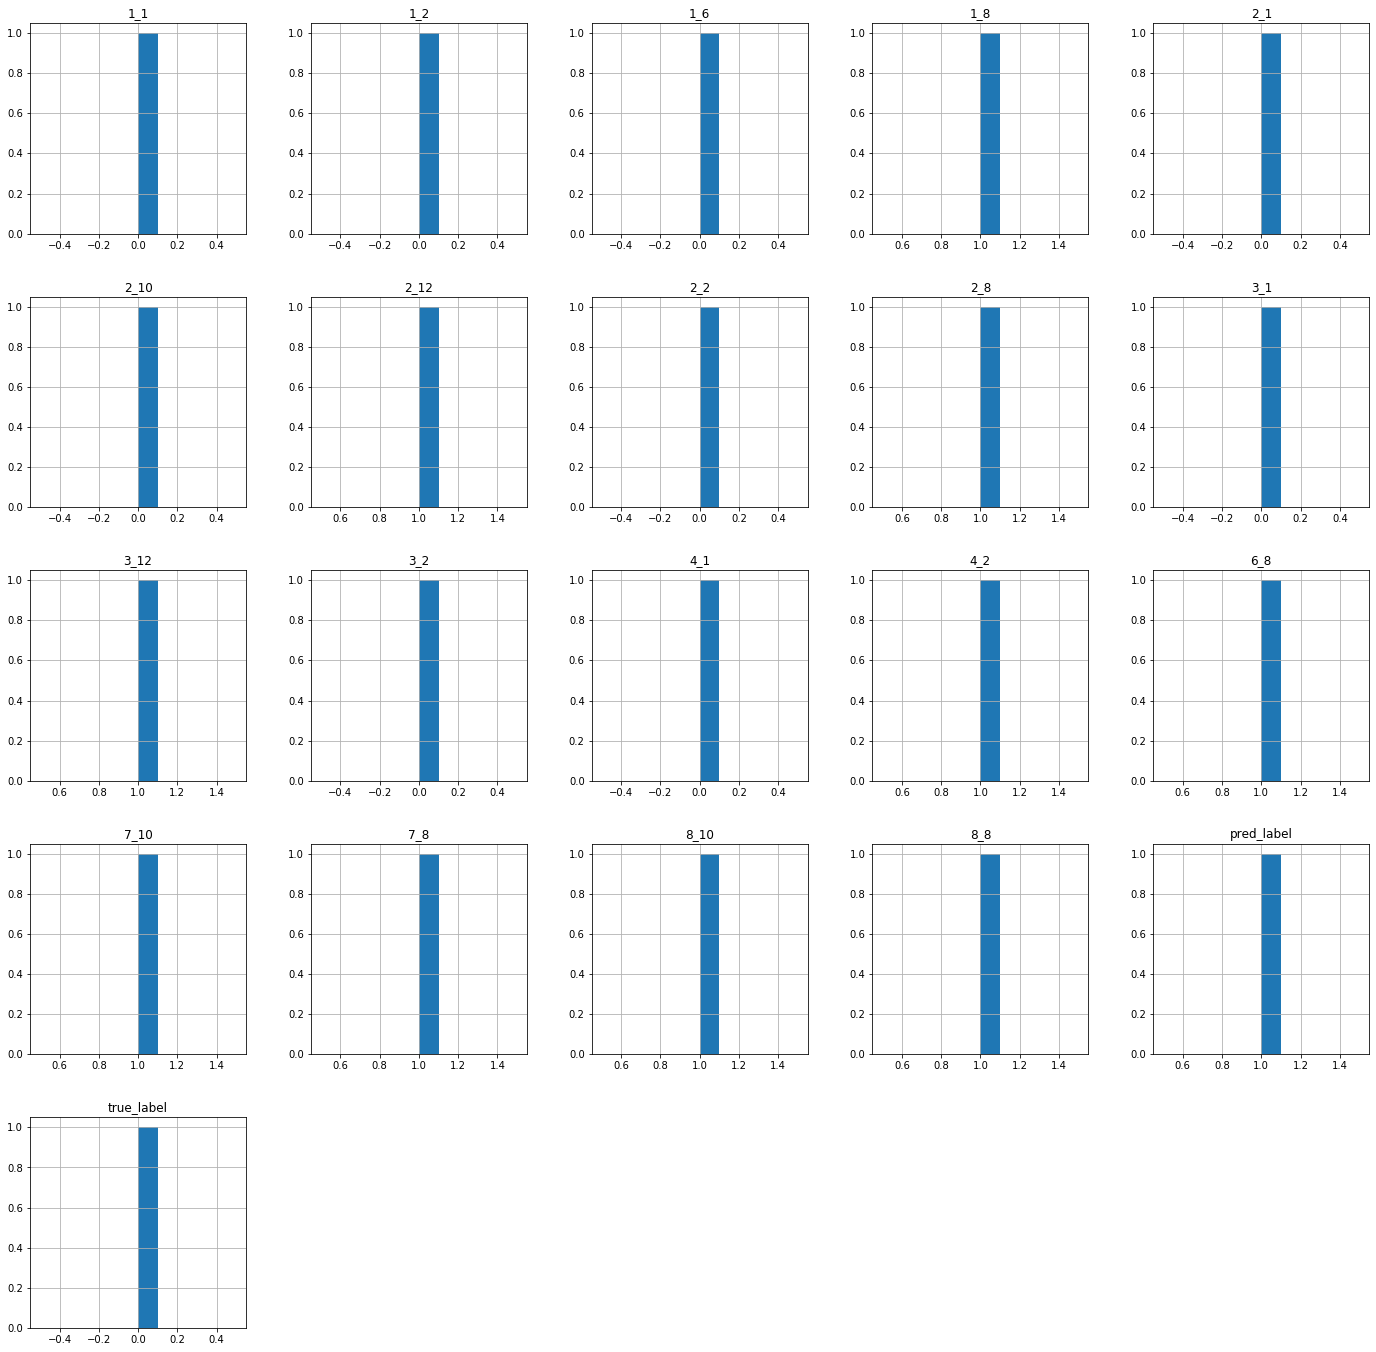

In [78]:
print_hist_models_predictions_fp(df_fp)

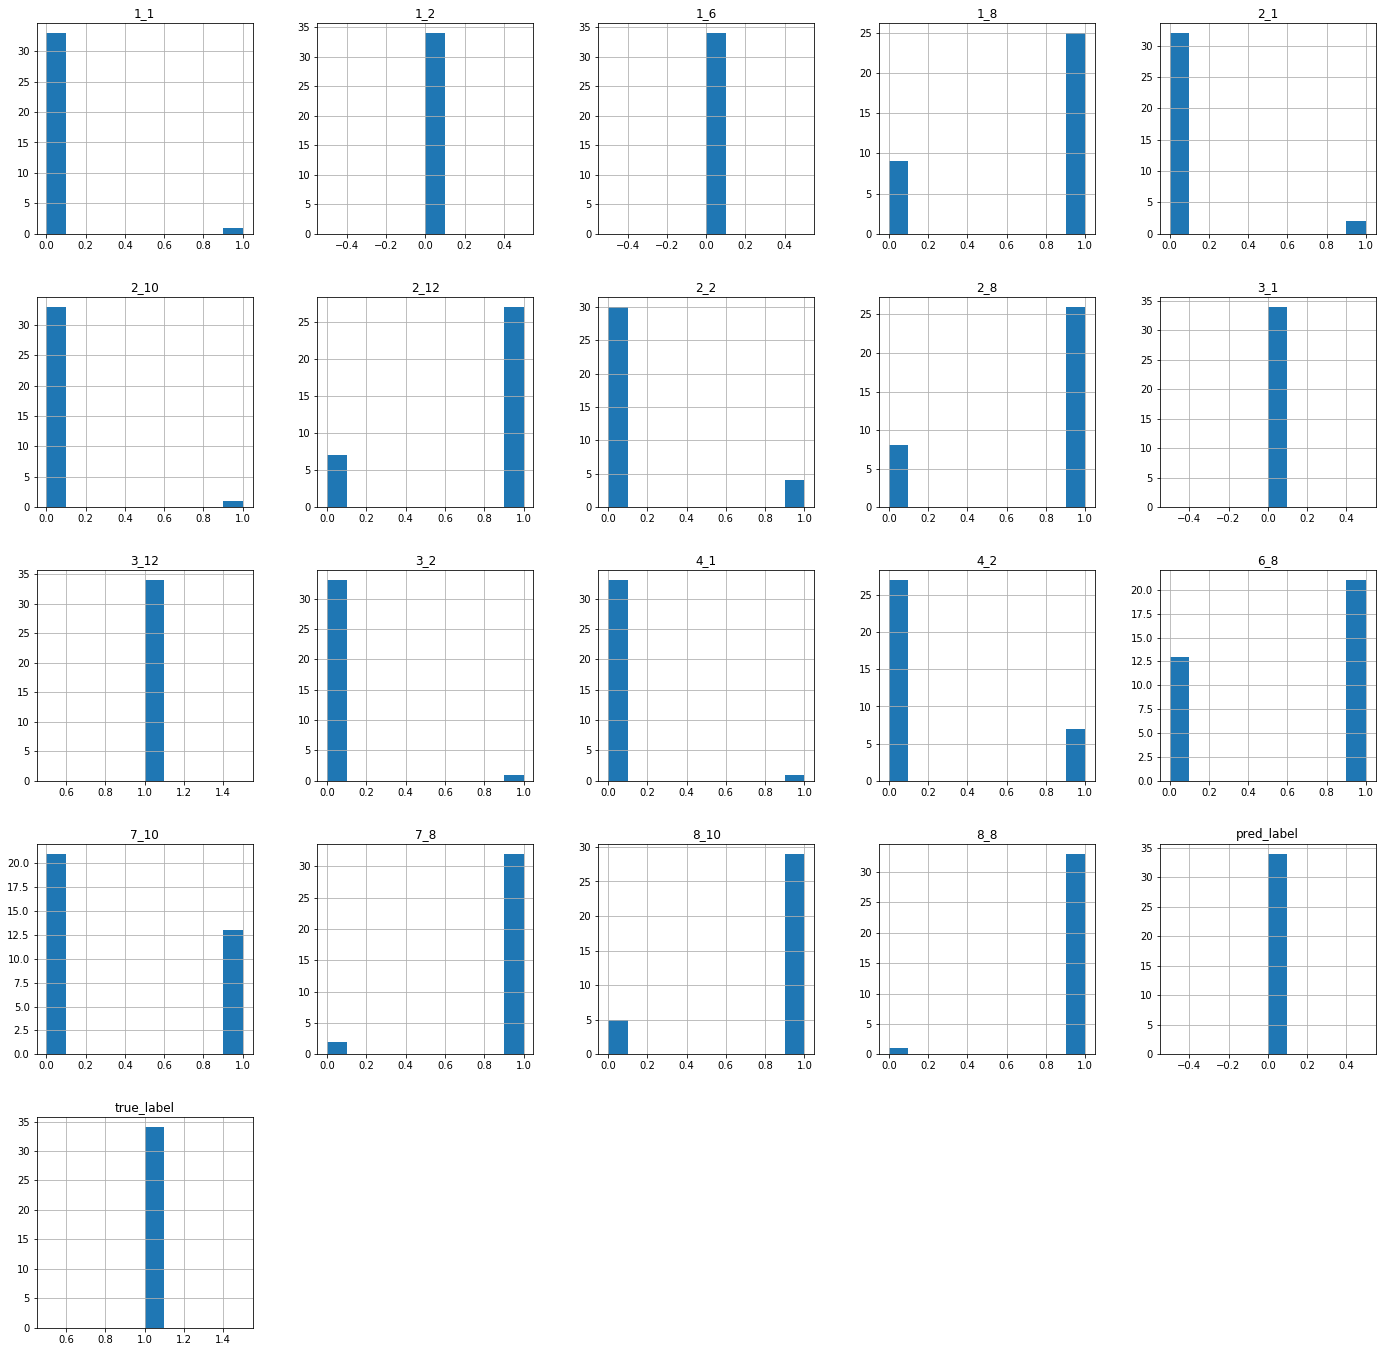

In [79]:
print_hist_models_predictions_fn(df_fn)

In [80]:
print(classification_report(df_res.true_label, df_res.pred_label))

              precision    recall  f1-score   support

           0       0.24      0.92      0.39        12
           1       0.93      0.29      0.44        48

    accuracy                           0.42        60
   macro avg       0.59      0.60      0.42        60
weighted avg       0.80      0.42      0.43        60



In [81]:
csv_path = "/Users/helemanc/PycharmProjects/ambient-intelligence/speech_emotion_recognition/ensemble_validation_results/majority_validation_crema_0_7.csv"
df_res.to_csv(csv_path)